In [29]:
#import custom functions for data pre-processing
from sentiment_utilities import load_combine_split, tokenize, process_data, vector_agg, embed_prep

#import modelling/data transform packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import xgboost as xgb

#import utility packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

In [ ]:
#if needed install fasttext
#!pip install fasttext

In [35]:
#import fasttext model
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

In [2]:
#path to data
path = '/Users/kknf069/Documents/Training/NLP/data/sentiment_labelled_sentences/'

## Load Data

In [3]:
train, validate = load_combine_split(path)

Train and test appropriately split
Train shape is 1924 rows and 3 columns.
Validate shape is 824 rows and 3 columns.


## TFIDF Experiment 0: Unsupervised analysis of training data

In [4]:
train_X, train_y, val_X, val_y = process_data(train, validate, tfidf = True)

In [5]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_df=0.9)
Xtr = vectorizer.fit_transform(train_X)

In [10]:
svd = TruncatedSVD(n_components=2, random_state=42)
data = svd.fit_transform(Xtr)

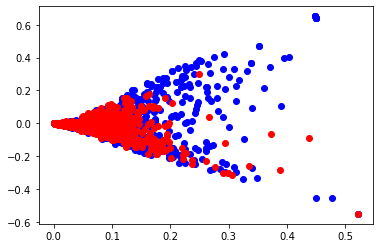

In [11]:
pos = []
neg = []
for i in range(len(train_y)):
    if train_y[i] =='1':
        pos.append(data[i])
    else:
        neg.append(data[i])

plt.scatter([i[0] for i in pos],
            [i[1] for i in pos], color = 'b')
plt.scatter([i[0] for i in neg],
            [i[1] for i in neg], color = 'r')
plt.show()

In [12]:
print(svd.explained_variance_ratio_.sum())

0.01559995374298759


In [13]:
#explained variance with more components (300)
svd = TruncatedSVD(n_components=300, random_state=42)
data = svd.fit(Xtr)
print(svd.explained_variance_ratio_.sum())

0.5765152986106453


## Experiment 1: Unigram only TFIDF

In [14]:
vectorizer = TfidfVectorizer()
Xtr = vectorizer.fit_transform(train_X)
Xval = vectorizer.transform(val_X)

In [15]:
model = RandomForestClassifier()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, Xtr, train_y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print(results)

/Users/kknf069/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy: 76.61% (3.37%)
[0.80310881 0.82901554 0.76683938 0.77202073 0.77604167 0.72395833
 0.70833333 0.78125    0.75       0.75      ]


In [16]:
rf = RandomForestClassifier()
unimod = rf.fit(Xtr, train_y)
pred_class = unimod.predict(Xval)
pred_prob_u = unimod.predict_proba(Xval)

## Experiment 2: Unigram+Bigram TFIDF

In [17]:
vectorizer_bi = TfidfVectorizer(ngram_range=(1,2))
Xtr_bi = vectorizer_bi.fit_transform(train_X)
Xval_bi = vectorizer_bi.transform(val_X)

In [18]:
model = RandomForestClassifier()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, Xtr_bi, train_y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print(results)

/Users/kknf069/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy: 75.98% (4.58%)
[0.79792746 0.82901554 0.74093264 0.78756477 0.77604167 0.68229167
 0.703125   0.79166667 0.78125    0.70833333]


In [19]:
rf = RandomForestClassifier()
unimod = rf.fit(Xtr_bi, train_y)
pred_class = unimod.predict(Xval_bi)
pred_prob_b = unimod.predict_proba(Xval_bi)

## Experiment 3 XG Boost with UniGram 

In [21]:
model = xgb.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, Xtr, train_y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print(results)

/Users/kknf069/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy: 75.10% (3.17%)
[0.78238342 0.79792746 0.73056995 0.79274611 0.70833333 0.72916667
 0.703125   0.75520833 0.76041667 0.75      ]


In [23]:
xg = xgb.XGBClassifier()
unimod = xg.fit(Xtr, train_y)
pred_class = unimod.predict(Xval)
pred_prob_x = unimod.predict_proba(Xval)

## Combine into single frame

In [26]:
u = [i[1] for i in pred_prob_u]
b =[i[1] for i in pred_prob_b]
x = [i[1] for i in pred_prob_x]
label=np.array([int(i) for i in val_y])

In [27]:
frame = []
for i in range(len(u)):
    frame.append([ round(u[i],2),
                   round(b[i],2),
                   round(x[i],2),
                   round((u[i]+b[i]+x[i])/3, 2),
                   int(val_y[i]),  
                 ])

In [30]:
df_scores = pd.DataFrame(frame, columns=['rf_uni', 'rf_uni_bi', 'xgb_uni', 'avg_3', 'class'])

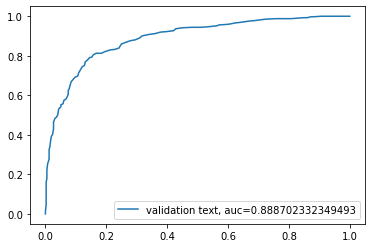

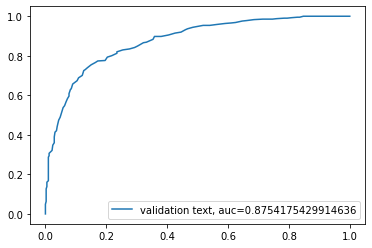

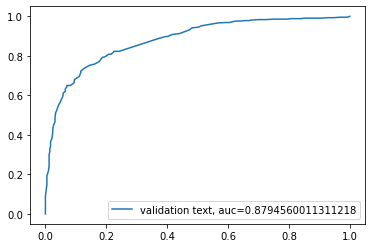

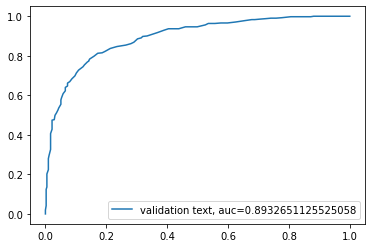

In [31]:
for i in ['rf_uni', 'rf_uni_bi', 'xgb_uni', 'avg_3']:
    fpr, tpr, _ = metrics.roc_curve(df_scores['class'],  df_scores[i])
    auc = metrics.roc_auc_score(df_scores['class'],  df_scores[i])
    plt.plot(fpr,tpr,label="validation text, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

## Experiment with fastext pretrained model

In [32]:
#custom punct removal list
punct = ('').join([i for i in string.punctuation if i != "'"])

In [33]:
train_X, train_y, val_X, val_y = process_data(train, validate, tfidf = False)

## Unsupervised vizualization

In [36]:
X_train_vec = embed_prep(ft, train_X, punct)
pca = PCA(n_components=2, svd_solver='full')
twod_pca= pca.fit_transform(X_train_vec)

(1924, 300)


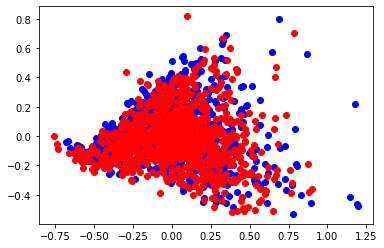

In [37]:
pos = []
neg = []
for i in range(len(train_y)):
    if train_y[i] =='1':
        pos.append(twod_pca[i])
    else:
        neg.append(twod_pca[i])

plt.scatter([i[0] for i in pos],
            [i[1] for i in pos], color = 'b')
plt.scatter([i[0] for i in neg],
            [i[1] for i in neg], color = 'r')
plt.show()

## FastText Experiment 1: Random Forest

In [38]:
model = RandomForestClassifier()
kfold = KFold(n_splits=5, random_state=7)
results = cross_val_score(model, X_train_vec, train_y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print(results)

/Users/kknf069/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy: 72.25% (2.17%)
[0.75324675 0.72207792 0.68571429 0.72987013 0.72135417]


In [42]:
X_val_vec = embed_prep(ft, val_X, punct)
rf = RandomForestClassifier()
rfft = rf.fit(X_train_vec, train_y)
pred_class = rfft.predict(X_val_vec)
pred_prob_rfft = rfft.predict_proba(X_val_vec)

(824, 300)


## FastText Experiment 2: XGBoost w/ Grid Search

In [40]:
def xbg_crossval(e, md, ns, X_train_vec, train_y):
    model = xgb.XGBClassifier(eta = e, max_depth=md)
    kfold = KFold(n_splits=ns, random_state=7)
    results = cross_val_score(model, X_train_vec, train_y, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    print(results)

In [41]:
for e in [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]:
    for md in range(4, 12, 2):
        print("\n===========================================")
        print('eta = '+str(e))
        print('max_depth = '+str(md))
        xbg_crossval(e, md, 5, X_train_vec, train_y)
'''
===========================================
eta = 0.1
max_depth = 4
Accuracy: 76.35% (2.34%)
[0.76363636 0.76623377 0.76623377 0.7974026  0.72395833]
'''


eta = 0.025
max_depth = 4


/Users/kknf069/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy: 71.83% (3.11%)
[0.75584416 0.75064935 0.67792208 0.69090909 0.71614583]

eta = 0.025
max_depth = 6
Accuracy: 72.82% (2.20%)
[0.74805195 0.75064935 0.6961039  0.73766234 0.70833333]

eta = 0.025
max_depth = 8
Accuracy: 72.30% (1.42%)
[0.72987013 0.73766234 0.6961039  0.72727273 0.72395833]

eta = 0.025
max_depth = 10
Accuracy: 71.93% (1.73%)
[0.72727273 0.74025974 0.68831169 0.72467532 0.71614583]

eta = 0.05
max_depth = 4
Accuracy: 73.65% (2.72%)
[0.77142857 0.76363636 0.6987013  0.72207792 0.7265625 ]

eta = 0.05
max_depth = 6
Accuracy: 73.70% (1.54%)
[0.75584416 0.74805195 0.71168831 0.74025974 0.72916667]

eta = 0.05
max_depth = 8
Accuracy: 73.60% (2.39%)
[0.74805195 0.76623377 0.6961039  0.72467532 0.74479167]

eta = 0.05
max_depth = 10
Accuracy: 73.91% (2.02%)
[0.76623377 0.75324675 0.70649351 0.73246753 0.73697917]

eta = 0.075
max_depth = 4
Accuracy: 74.74% (1.92%)
[0.77402597 0.75844156 0.72207792 0.75324675 0.72916667]

eta = 0.075
max_depth = 6
Accuracy: 74.64% (1.9

'\n===========================================\neta = 0.1\nmax_depth = 4\nAccuracy: 76.35% (2.34%)\n[0.76363636 0.76623377 0.76623377 0.7974026  0.72395833]\n'

In [43]:
xg = xgb.XGBClassifier(eta = 0.2, max_depth = 4)
xgft = xg.fit(X_train_vec, train_y)
pred_class = xgft.predict(X_val_vec)
pred_prob_xgft = xgft.predict_proba(X_val_vec)

## Combine all models into one dataframe for analysis

In [44]:
u = [i[1] for i in pred_prob_u]
b =[i[1] for i in pred_prob_b]
x = [i[1] for i in pred_prob_x]
rft= [i[1] for i in pred_prob_rfft]
xft =[i[1] for i in pred_prob_xgft]
label=np.array([int(i) for i in val_y])

In [45]:
frame = []
for i in range(len(u)):
    frame.append([ round(u[i],2),
                   round(b[i],2),
                   round(x[i],2),
                   round(rft[i],2),
                   round(xft[i],2),
                   round((u[i]+b[i]+x[i])/3, 2),
                   round((u[i]+b[i]+x[i]+rft[i]+xft[i])/5, 2),
                   int(val_y[i]),  
                 ])

In [46]:
df_scores = pd.DataFrame(frame, columns=['rf_uni', 
                                         'rf_uni_bi', 
                                         'xgb_uni',
                                         'rf_ft',
                                         'xgb_ft',
                                         'avg_3_tfidf',
                                         'avg_5_models',
                                         'class'])


ROC Curve for rf_uni


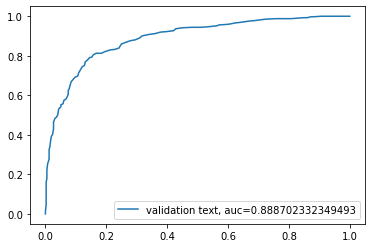


ROC Curve for rf_uni_bi


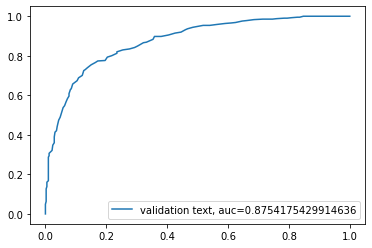


ROC Curve for xgb_uni


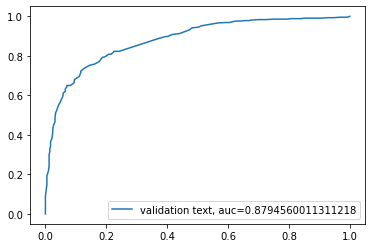


ROC Curve for rf_ft


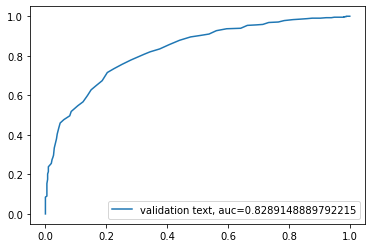


ROC Curve for xgb_ft


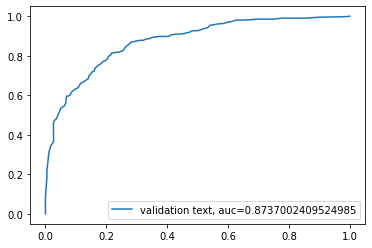


ROC Curve for avg_3_tfidf


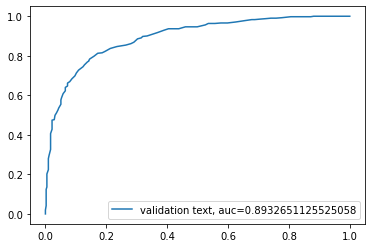


ROC Curve for avg_5_models


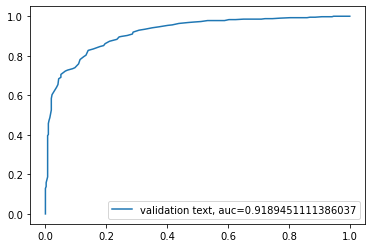

In [47]:
for i in ['rf_uni', 
          'rf_uni_bi', 
          'xgb_uni',
          'rf_ft',
          'xgb_ft',
          'avg_3_tfidf',
          'avg_5_models']:
    print('\nROC Curve for '+ i)
    fpr, tpr, _ = metrics.roc_curve(df_scores['class'],  df_scores[i])
    auc = metrics.roc_auc_score(df_scores['class'],  df_scores[i])
    plt.plot(fpr,tpr,label="validation text, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()